In [1]:
# Set up for the project
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras import backend as K
from keras import regularizers
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imresize

import os
project_dir = os.getcwd()
model_dir = project_dir + "/models/"

vgg_model_loc = model_dir + "vgg11.h5"
vgg_json_loc = model_dir + "vgg11.json"

Using TensorFlow backend.


In [2]:
# Get the original dimension of dataset
(X_train_orig, Y_train), (X_test_orig, Y_test) = mnist.load_data()
print("Training data shape: ", X_train_orig.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test_orig.shape)
print("Test labels shape: ", Y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [3]:
# Cut the traning and testing set by 1/10 to reduce operation time
num_train = 60000
mask_train = range(num_train)
X_train_orig = X_train_orig[mask_train]
Y_train = Y_train[mask_train]

num_test = 10000
mask_test = range(num_test)
X_test_orig = X_test_orig[mask_test]
Y_test = Y_test[mask_test]

print("Training data shape: ", X_train_orig.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test_orig.shape)
print("Test labels shape: ", Y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


The four randomly-chosen numbers are: 51006 59806 2371 4889
The size of the 4 randomly-chosen images are:  (32, 32) (32, 32) (32, 32) (32, 32)
The corresponding labels for the 4 images are: 0 1 9 0


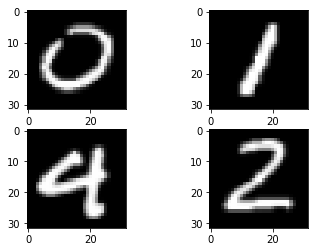

In [4]:
# Resize all images in training and test sets
X_train = np.zeros((num_train,32,32))
X_test = np.zeros((num_test,32,32))

for i in range(num_train):
    X_train[i] = imresize(X_train_orig[i],(32,32))

for j in range(num_test):
    X_test[j] = imresize(X_test_orig[j],(32,32))

# Test with some random images
a = random.randint(0,num_train)
b = random.randint(0,num_train)
c = random.randint(0,num_test)
d = random.randint(0,num_test)
plt.subplot(221)
plt.imshow(X_train[a], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[b], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_test[c], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_test[d], cmap=plt.get_cmap('gray'))

print("The four randomly-chosen numbers are:", a,b,c,d)
print("The size of the 4 randomly-chosen images are: ",X_train[a].shape, X_train[b].shape, 
                                                     X_test[c].shape, X_test[d].shape)
print("The corresponding labels for the 4 images are:", Y_train[a], Y_train[b], Y_train[c], Y_train[d])

In [5]:
# Preprocessing: reshape the image data into rows
img_rows = 32
img_cols = 32
num_classes = 10
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Preprocessing: subtract the mean image
train_mean = np.mean(X_train,axis=0)
test_mean = np.mean(X_test,axis=0)
X_train -= train_mean
X_test -= test_mean

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train,num_classes)
Y_test = keras.utils.to_categorical(Y_test,num_classes)

print("Training data shape: ", X_train.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test.shape)
print("Test labels shape: ", Y_test.shape)
print("Input shape: ", input_shape)

Training data shape:  (60000, 32, 32, 1)
Training labels shape:  (60000, 10)
Testing data shape:  (10000, 32, 32, 1)
Test labels shape:  (10000, 10)
Input shape:  (32, 32, 1)


In [6]:
# Define the VGG-11 model, VGG paper model A
# Use same padding since the input shape(32,32,3) for this project is significantly smaller than that in the paper(224,224,3)
def VGG_model():
    model = Sequential()
    regu = 5e-4
    model.add(Conv2D(64,(3,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regu)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regu)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile model
#     learning_rate = 0.01
#     decay = learning_rate/epochs
#     adam_customized = keras.optimizers.Adam(lr=learning_rate,decay=decay)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [7]:
# Build the vgg model
vgg11_model = VGG_model()
vgg11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)       0         
__________

In [8]:
# Modify the hyperparameters here
batch_size = 512
epochs = 10

In [ ]:
# define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
vgg11_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),steps_per_epoch=len(X_train), epochs=epochs)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (60000, 32, 32, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/10
  919/60000 [..............................] - ETA: 2689456s - loss: 0.5647 - acc: 0.9717